# Обработка

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print(tf.__version__)

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download ml-intensive-of-yandex-academy-2023
!unzip ml-intensive-of-yandex-academy-2023.zip 

train_data = pd.read_pickle('data_train')
test_data = pd.read_pickle('data_test')
x_test = test_data['images'] / 255.0
print(f'Train data keys: {train_data.keys()}')
print(f'Test data keys: {test_data.keys()}\n')
print(f'Shape of train images: {train_data["images"].shape}')
print(f'Shape of test images: {test_data["images"].shape}\n')
print(f'Unique labels: {set(train_data["labels"])}\n')
print(f'Classes distribution: {pd.Series(train_data["labels"]).value_counts(normalize=True)}')

2.12.0
 90% 238M/263M [00:01<00:00, 226MB/s]
100% 263M/263M [00:01<00:00, 217MB/s]
Archive:  ml-intensive-of-yandex-academy-2023.zip
  inflating: data_test               
  inflating: data_train              
  inflating: meta                    
Train data keys: dict_keys(['section', 'labels', 'images'])
Test data keys: dict_keys(['section', 'images'])

Shape of train images: (50000, 32, 32, 3)
Shape of test images: (25000, 32, 32, 3)

Unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

Classes distribution: 1    0.19300
2    0.15190
3    0.11250
4    0.09882
5    0.09208
7    0.07752
6    0.07718
0    0.06682
8    0.06664
9    0.06354
dtype: float64


In [3]:
def black_white_point(image):
    # получаем координаты черных пикселей
  black_pixels = np.where(np.all(image == [0, 0, 0], axis=-1))
  # print('Removing black pixels...')

  # заменяем черные пиксели на среднее значение пикселей в окрестности 3x3
  for i, j in zip(black_pixels[0], black_pixels[1]):
      # получаем окрестность 3x3 пикселя
      neighborhood = image[max(0, i-1):min(i+2, image.shape[0]), max(0, j-1):min(j+2, image.shape[1])].reshape((-1, 3))
      # отсеиваем соль и перец чтобы не мешались
      neighborhood1 = neighborhood[np.nonzero(np.sum(neighborhood, axis=1))]
      neighborhood1 = neighborhood1[np.nonzero(np.sum(neighborhood1, axis=1) != 255*3)]
      if not neighborhood1.any():  # на случай если пиксель полностью окружён шумом
          neighborhood1 = neighborhood
      # считаем среднее значение пикселей
      mean_pixel = np.mean(neighborhood1, axis=0)
      # заменяем черный пиксель на среднее значение
      image[i, j] = mean_pixel


  # получаем координаты белых пикселей
  white_pixels = np.where(np.all(image == [255, 255, 255], axis=-1))
  # print('Removing white pixels...')

  # заменяем черные пиксели на среднее значение пикселей в окрестности 3x3
  for i, j in zip(white_pixels[0], white_pixels[1]):
      # получаем окрестность 3x3 пикселя
      neighborhood = image[max(0, i-1):min(i+2, image.shape[0]), max(0, j-1):min(j+2, image.shape[1])].reshape((-1, 3))
      # отсеиваем соль и перец чтобы не мешались
      neighborhood1 = neighborhood[np.nonzero(np.sum(neighborhood, axis=1))]
      neighborhood1 = neighborhood1[np.nonzero(np.sum(neighborhood1, axis=1) != 255*3)]
      if not neighborhood1.any():  # на случай если пиксель полностью окружён шумом
          neighborhood1 = neighborhood
      # считаем среднее значение пикселей
      mean_pixel = np.mean(neighborhood1, axis=0)
      # заменяем белый пиксель на среднее значение
      image[i, j] = mean_pixel

In [5]:
for image in train_data['images']:
  black_white_point(image)

for image in test_data['images']:
  black_white_point(image)

In [6]:
orig_ds = tf.data.Dataset.from_tensor_slices((train_data['images'], train_data['labels']))
test_ds = tf.data.Dataset.from_tensor_slices((test_data['images']))

data_augmentation = tf.keras.Sequential([
  # layers.RandomZoom(0.2),
  layers.RandomRotation(0.15),
])

augmented_train_dataset = orig_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

dataset = augmented_train_dataset.cache()

In [11]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE
IMG_SIZE = 32

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets.
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets.
  ds = ds.batch(batch_size).map(lambda x, y: (x, tf.one_hot(y, depth=10)))

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

def prepare_test(ds):
  return ds.map(lambda x: resize_and_rescale(x), 
              num_parallel_calls=AUTOTUNE)

In [27]:
unet_orig_ds = orig_ds  # без обрезания картинки по краям
len_orig_ds = len(orig_ds)
unet_val_ds, unet_train_ds = unet_orig_ds.take(int(len_orig_ds* 0.15)) , unet_orig_ds.skip(int(len_orig_ds * 0.15))

orig_ds = augmented_train_dataset
len_orig_ds = len(orig_ds)
orig_val_ds, orig_train_ds = orig_ds.take(int(len_orig_ds* 0.15)) , orig_ds.skip(int(len_orig_ds * 0.15))

In [28]:
full_train_ds = prepare(orig_train_ds, shuffle=True)
val_ds = prepare(orig_val_ds)
unet_full_train_ds = prepare(unet_train_ds, shuffle=True)
unet_val_ds = prepare(orig_val_ds)
test_ds = prepare_test(test_ds)

In [14]:
def crop_image(image):
    cropped_image = tf.image.crop_to_bounding_box(image, 0, 3, 32, 26)
    return cropped_image

full_train_ds = full_train_ds.map(lambda x, y: (crop_image(x), y))
val_ds = val_ds.map(lambda x, y: (crop_image(x), y))
test_ds = test_ds.map(lambda x: crop_image(x))

In [15]:
len(full_train_ds) * batch_size

42528

In [16]:
len(val_ds) * batch_size

7520

In [19]:
! pip install livelossplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Baseline

In [21]:
from tensorflow.keras import layers

#СОЗДАЕМ МОДЕЛЬ 
input_shape = (32, 26, 3)

dense_model = tf.keras.Sequential([
    layers.Input(shape=input_shape), 
    layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(), 
    layers.Dropout(0.2),         
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),  
    layers.Dropout(0.2),         
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),  
    layers.Dropout(0.2),        
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(160, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(40, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    layers.Dropout(0.2),
    tf.keras.layers.Dense(10)
])
#ИСПОЛЬЗУЕМ CategoricalCrossentropy

dense_model.compile(
    optimizer='sgd',
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['categorical_accuracy'])

In [18]:
dense_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 16)        448       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 16)       64        
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 32, 32, 16)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        4640      
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 32)      

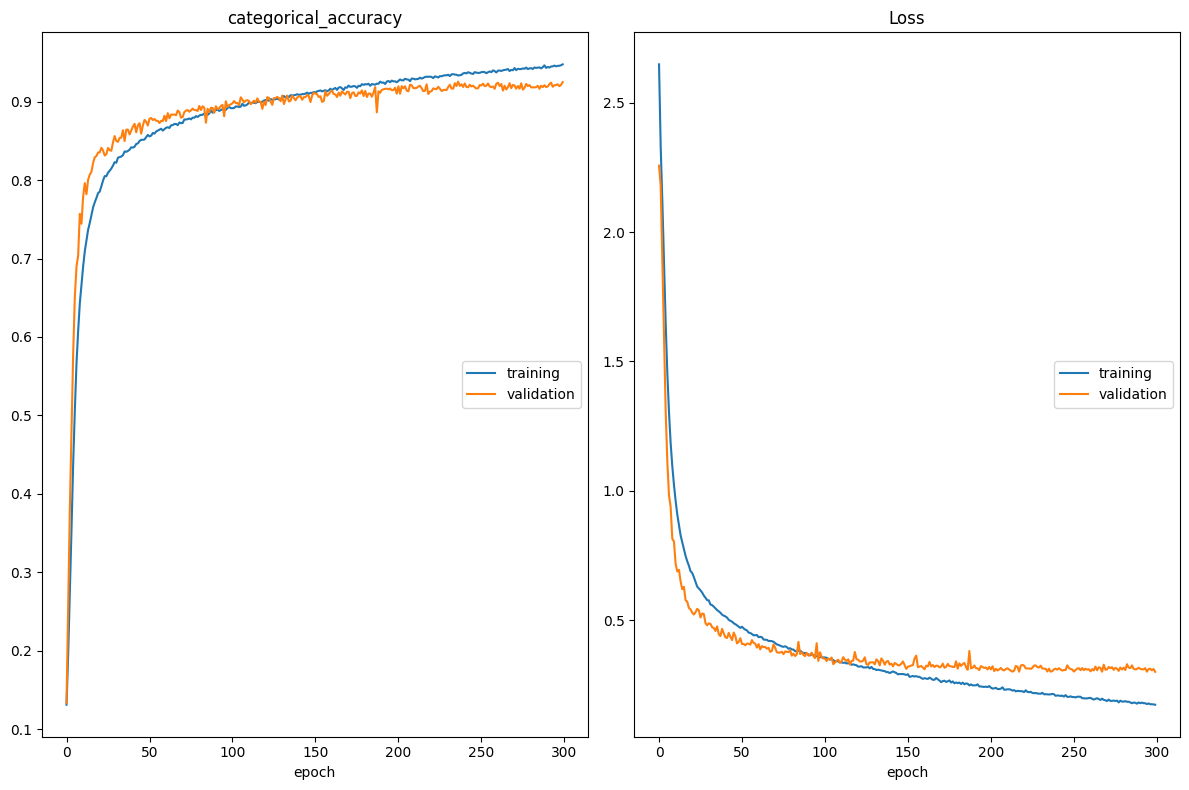

categorical_accuracy
	training         	 (min:    0.131, max:    0.948, cur:    0.948)
	validation       	 (min:    0.133, max:    0.926, cur:    0.925)
Loss
	training         	 (min:    0.173, max:    2.649, cur:    0.173)
	validation       	 (min:    0.300, max:    2.257, cur:    0.300)
Время: 1141.240829706192 секунд


In [ ]:
from livelossplot import PlotLossesKeras
import time 

start = time.time() 
dense_model_history = dense_model.fit(train_dataset, validation_data=val_dataset, epochs=300, callbacks=[PlotLossesKeras()], verbose=False)
end = time.time() - start 
print("Время: "+ str(end) +' секунд') 

# Unet

In [22]:
from tensorflow.keras import layers

#СОЗДАЕМ МОДЕЛЬ 
input_shape = (32, 32, 3)

import tensorflow as tf
from tensorflow import keras

# Определяем блок свертки и сжатия
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0, 0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(layers.BatchNormalization())
    
    result.add(layers.Dropout(0.5))

    result.add(layers.LeakyReLU())

    return result

# Определяем блок развертки и расширения
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0, 0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))
    result.add(layers.BatchNormalization())

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

# Определяем модель U-Net
def unet_model(input_shape=input_shape):
    inputs = layers.Input(shape=input_shape)
    # Применяем 4 блока свертки и сжатия
    down_stack = [
        downsample(64, 4),  # (bs, 128, 128, 64)
        downsample(128, 4),  # (bs, 64, 64, 128)
        downsample(256, 4),  # (bs, 32, 32, 256) # (bs, 16, 16, 512)
    ]

    # Применяем 4 блока развертки и расширения
    up_stack = [  # (bs, 32, 32, 1024)
        upsample(256, 4, apply_dropout=True),  # (bs, 64, 64, 512)
        upsample(128, 4, apply_dropout=True),  # (bs, 128, 128, 256)
        upsample(64, 4, apply_dropout=True),  # (bs, 256, 256, 128)
    ]

    # Применяем блок прямого пути
    last = layers.Conv2DTranspose(3, 4, strides=2,
                                   padding='same',
                                   kernel_initializer=tf.random_normal_initializer(0, 0.02),
                                   activation='sigmoid')  # (bs, 256, 256, 3)

    x = inputs

    # Проходим через блоки свертки и сжатия
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Проходим через блоки развертки и расширения
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

#ИСПОЛЬЗУЕМ CategoricalCrossentropy
unet_model = keras.Sequential()
unet_model.add(unet_model(input_shape))

unet_model_help = tf.keras.Sequential([
    layers.Input(shape=input_shape), 
    layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(), 
    layers.Dropout(0.4),         
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),  
    layers.Dropout(0.4),         
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),  
    layers.Dropout(0.4),        
    layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    layers.Dropout(0.2),
    tf.keras.layers.Dense(10)
])

unet_model.add(unet_model_help)

unet_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['categorical_accuracy'])


TypeError: ignored

In [ ]:
unet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 32, 32, 3)         2505987   
                                                                 
 sequential_8 (Sequential)   (None, 10)                2391530   
                                                                 
Total params: 4,897,517
Trainable params: 4,894,605
Non-trainable params: 2,912
_________________________________________________________________


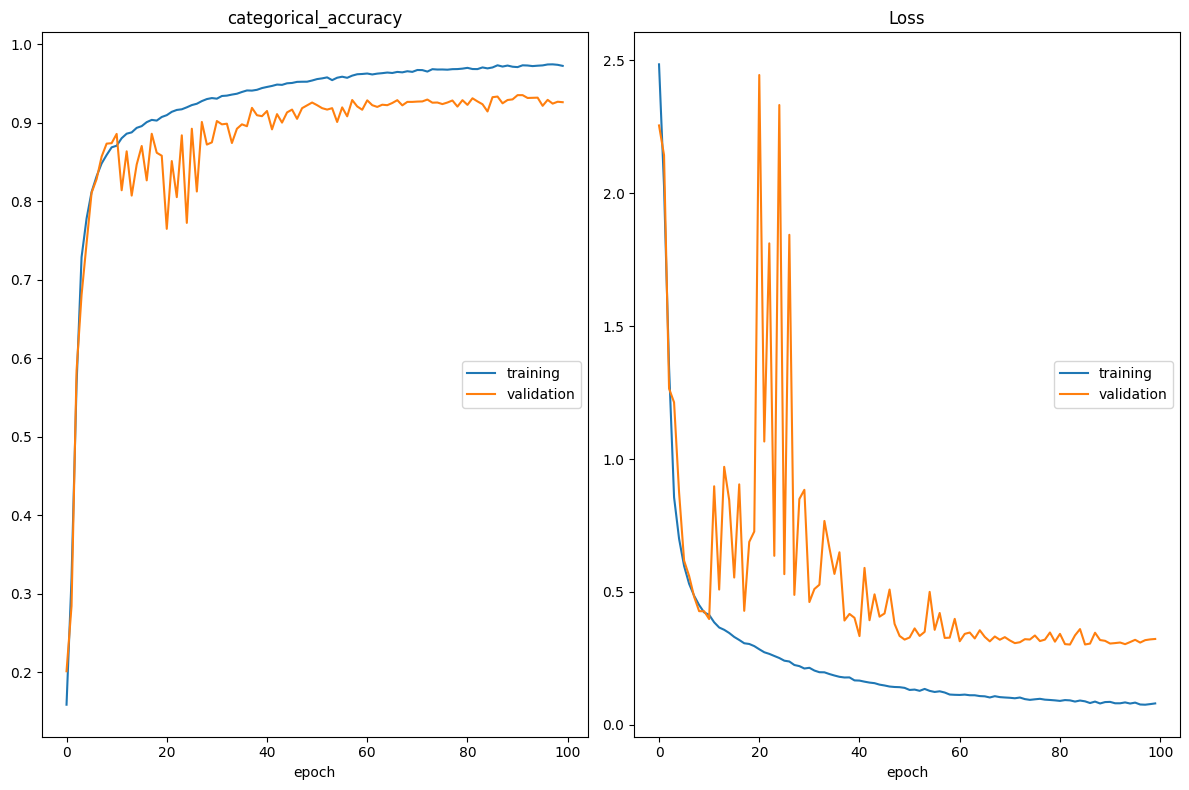

categorical_accuracy
	training         	 (min:    0.159, max:    0.975, cur:    0.973)
	validation       	 (min:    0.201, max:    0.935, cur:    0.926)
Loss
	training         	 (min:    0.075, max:    2.485, cur:    0.080)
	validation       	 (min:    0.302, max:    2.445, cur:    0.323)
Время: 1663.5679552555084 секунд


In [ ]:
from livelossplot import PlotLossesKeras
import time 

start = time.time() 
unet_model_history = unet_model.fit(unet_full_train_ds, validation_data=unet_val_ds, epochs=100, callbacks=[PlotLossesKeras()], verbose=False)
end = time.time() - start 
print("Время: "+ str(end) +' секунд') 

# RESNET

In [23]:
from tensorflow.keras import layers

#СОЗДАЕМ МОДЕЛЬ 
input_shape = (32, 26, 3)

import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, BatchNormalization, Activation, Add,Dropout


# Определение функции для создания Residual блоков
def residual_block(inputs, num_filters, kernel_size, strides):
    x = Conv2D(num_filters, kernel_size=kernel_size, strides=strides, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Activation('relu')(x)
    x = Conv2D(num_filters, kernel_size=kernel_size, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Add()([x, inputs])
    x = Activation('relu')(x)
    return x

# Создание модели ResNet-50 архитектуры
inputs = Input(shape=input_shape)
x = Conv2D(64, kernel_size=3, strides=1, padding='same')(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = residual_block(x, 64, 3, 1)
x = residual_block(x, 64, 3, 1)
x = residual_block(x, 64, 3, 1)
x = Conv2D(128, kernel_size=3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Activation('relu')(x)
x = residual_block(x, 128, 3, 1)
x = residual_block(x, 128, 3, 1)
x = residual_block(x, 128, 3, 1)
x = Conv2D(256, kernel_size=3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Activation('relu')(x)
x = residual_block(x, 256, 3, 1)
x = residual_block(x, 256, 3, 1)
x = residual_block(x, 256, 3, 1)
x = Flatten()(x)
outputs = Dense(10, activation='softmax')(x)
model = Model(inputs, outputs)


# Компиляция и обучение модели
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [24]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32, 26, 3)]  0           []                               
                                                                                                  
 conv2d_6 (Conv2D)              (None, 32, 26, 64)   1792        ['input_3[0][0]']                
                                                                                                  
 batch_normalization_8 (BatchNo  (None, 32, 26, 64)  256         ['conv2d_6[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation (Activation)        (None, 32, 26, 64)   0           ['batch_normalization_8[0][0]

In [ ]:
from livelossplot import PlotLossesKeras
import time 

start = time.time() 
model_history = model.fit(train_dataset, validation_data=val_dataset, epochs=100, callbacks=[PlotLossesKeras()], verbose=False)
end = time.time() - start 
print("Время: "+ str(end) +' секунд') 

In [ ]:
model.save("resnet")

# Densenet

In [26]:
from tensorflow.keras import layers

#СОЗДАЕМ МОДЕЛЬ 
import keras
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Conv3D, DepthwiseConv2D, SeparableConv2D, Conv3DTranspose
from keras.layers import Flatten, MaxPool2D, AvgPool2D, GlobalAvgPool2D, UpSampling2D, BatchNormalization
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from time import time
import numpy as np
     

import tensorflow as tf

def dense_block(x, blocks, name):
    for i in range(blocks):
        x1 = tf.keras.layers.BatchNormalization()(x)
        x1 = tf.keras.layers.Dropout(0.4)(x1)
        x1 = tf.keras.layers.ReLU()(x1)
        x1 = tf.keras.layers.Conv2D(12, 3, padding='same')(x1)
        x = tf.keras.layers.concatenate([x, x1], axis=-1, name=name+'_block'+str(i+1))
    return x

def transition_block(x, reduction, name):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Conv2D(int(tf.keras.backend.int_shape(x)[-1] * reduction), 1, padding='same')(x)
    x = tf.keras.layers.AveragePooling2D(2, strides=2)(x)
    return x

def densenet(input_shape=(32,26,3), num_classes=10):
    inputs = tf.keras.layers.Input(shape=input_shape)
    x = tf.keras.layers.Conv2D(64, 3, strides=1, use_bias=False)(inputs)

    x = dense_block(x, 6, name='dense_block1')
    x = transition_block(x, 0.5, name='transition_block1')

    x = dense_block(x, 12, name='dense_block2')
    x = transition_block(x, 0.5, name='transition_block2')

    x = dense_block(x, 24, name='dense_block3')
    x = transition_block(x, 0.5, name='transition_block3')

    x = dense_block(x, 16, name='dense_block4')

    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, x, name='densenet')
    return model
model = densenet()

# Компиляция и обучение модели
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

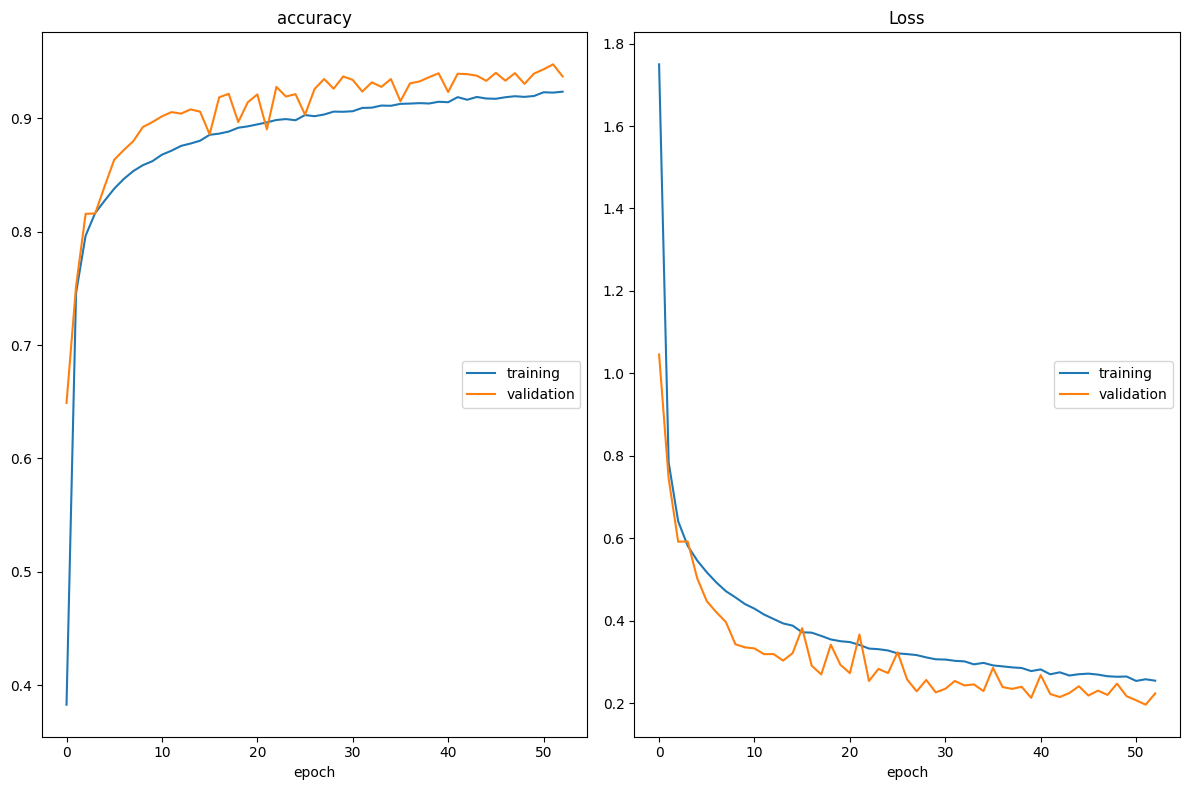

accuracy
	training         	 (min:    0.383, max:    0.924, cur:    0.924)
	validation       	 (min:    0.649, max:    0.948, cur:    0.937)
Loss
	training         	 (min:    0.254, max:    1.750, cur:    0.255)
	validation       	 (min:    0.196, max:    1.046, cur:    0.224)


In [ ]:
from livelossplot import PlotLossesKeras
import time 

start = time.time() 
model_history = model.fit(full_train_ds, validation_data=val_ds, epochs=100, callbacks=[PlotLossesKeras()], verbose=False)
end = time.time() - start 
print("Время: "+ str(end) +' секунд')

# Result

In [ ]:
import numpy as np 

# Приводим в единный массив из двойного (может есть оптимальней)
predictions = model.predict(x_test)
new_predictions = []
for i in predictions:
  i = list(i)
  max_i = max(i)
  index_max_i = i.index(max_i)
  new_predictions.append(index_max_i)


NameError: ignored

In [ ]:
import pandas as pd   #  pip install pandas

columns=['Id', 'Category']

data = []
data.append(np.arange(len(new_predictions)))
data.append(new_predictions)
data = np.array(data).T
df = pd.DataFrame(data, columns=columns)
df['Id'] = df['Id'].astype(int)

df.to_csv('/content/cartridge_accounting_resnet_new.csv', index= False )


NameError: ignored

In [ ]:
from keras.models import load_model

model.save('drive/MyDrive/my_model.h5')  # creates a HDF5 file 'my_model.h5'
del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
model = load_model('drive/MyDrive/my_model.h5')